In [1]:
import numpy as np
import cv2
import tensorflow as tf
import tensorflow.keras.layers as layers
from scripts.utils import *
from scripts.models import *
from scripts.rigid_transform import *
from scripts.loss import *
%load_ext autoreload
%autoreload 2

2021-12-23 14:38:32.722944: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/theo/miniconda3/envs/pytorch/lib/python3.9/site-packages/cv2/../../lib64:/usr/lib/cuda/include:/usr/lib/cuda/lib64:
2021-12-23 14:38:32.722980: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load Data

In [3]:
data = load_data("data/vessel_augmented/",target_size=(512,512))
train, test = split_dataset(data,balance=0.7,seed=120)
print(f"We have {train.shape[0]} training image pairs and {test.shape[0]} test image pairs.")

We have 277 training image pairs and 120 test image pairs.


In [4]:
u = cv2.resize(np.asarray(train[10][0][:,:,0]),(512,512))
v = cv2.resize(np.asarray(train[10][1][:,:,0]),(512,512))
show_images([u,v])

# Training

In [4]:
def training(train_data,epochs,batch_size,lr):
    # Shuffle and batch the dataset.
    from_tensor_slices = tf.data.Dataset.from_tensor_slices
    x_train = from_tensor_slices(train).shuffle(10000).batch(batch_size)
    model = simple_cnn(input_shape=(512,512,1))
    # optimizer set up
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    criterion = ncc_loss
    # Define the metrics to track training and testing losses.
    m_train = tf.keras.metrics.Mean(name='loss_train')
    for epoch in range(epochs):
        m_train.reset_states()
        for i, pair in enumerate(x_train):
            moving = pair[:,0,:,:,:]
            static = pair[:,1,:,:,:]
            #print(type(moving), moving.shape, type(static), static.shape)
            #show_images([moving[0],static[0]])
            loss_train = train_step(model, moving, static, criterion,
                                    optimizer)
            m_train.update_state(loss_train)
        print('Epoch: %3d/%d\tTrain Loss: %.6f'
              % (epoch + 1, epochs, m_train.result()))
    print('\n')
    return model

In [5]:
epoch = 20
batch_size = 8
lr = 0.01
model_post_training = training(train,epoch,batch_size,lr)
#model_post_training = training_mnist(train,test,epoch,batch_size,lr)

Neural Net output shape : (None, 3)
Shape of rotation matrix (None, 2, 2)
Final tranformation matrix shape : (None, 2, 3)
Epoch:   1/20	Train Loss: -0.929294
Epoch:   2/20	Train Loss: -0.931360
Epoch:   3/20	Train Loss: -0.931254
Epoch:   4/20	Train Loss: -0.931174
Epoch:   5/20	Train Loss: -0.931366
Epoch:   6/20	Train Loss: -0.931475
Epoch:   7/20	Train Loss: -0.930755
Epoch:   8/20	Train Loss: -0.931574
Epoch:   9/20	Train Loss: -0.931553
Epoch:  10/20	Train Loss: -0.931408
Epoch:  11/20	Train Loss: -0.931293
Epoch:  12/20	Train Loss: -0.931931
Epoch:  13/20	Train Loss: -0.931959
Epoch:  14/20	Train Loss: -0.931575
Epoch:  15/20	Train Loss: -0.931708
Epoch:  16/20	Train Loss: -0.932040
Epoch:  17/20	Train Loss: -0.932695
Epoch:  18/20	Train Loss: -0.932877
Epoch:  19/20	Train Loss: -0.933174
Epoch:  20/20	Train Loss: -0.934015




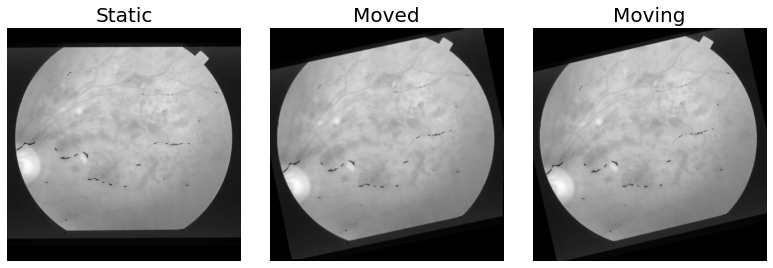

In [9]:
plot_images(model_post_training,test[10][1:],test[10][:1])

# MNIST

In [3]:
mnist_train, mnist_test = load_mnist(label=1)

In [4]:
print(mnist_train.shape)

(6742, 32, 32, 1)


In [5]:
def training_mnist(train_data,test_data,epochs,batch_size,lr,input_shape=(32,32,1)):
    x_train = train_data
    x_test = test_data
    # Shuffle and batch the dataset.
    from_tensor_slices = tf.data.Dataset.from_tensor_slices
    x_train = from_tensor_slices(x_train).shuffle(10000).batch(batch_size)
    model = simple_cnn(input_shape=input_shape)
    # pick static
    idx = np.random.randint(x_test.shape[0])
    print(f"Id of the static image : {idx}")
    static = tf.expand_dims(x_test[idx], axis=0)
    # optimizer set up
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    criterion = ncc_loss
    # Define the metrics to track training and testing losses.
    m_train = tf.keras.metrics.Mean(name='loss_train')
    for epoch in range(epochs):
        m_train.reset_states()
        for i, moving in enumerate(x_train):
            # extend static 
            num_batch, W, H, C = moving.shape  # moving.shape
            # Same static
            multiples = tf.constant([num_batch, 1, 1, 1], tf.int32)
            static_tmp = tf.tile(static, multiples)
            #print(type(moving), moving.shape, type(static_tmp), static_tmp.shape)
            loss_train = train_step(model, moving, static_tmp, criterion,
                                    optimizer)
            m_train.update_state(loss_train)
        print('Epoch: %3d/%d\tTrain Loss: %.6f'
              % (epoch + 1, epochs, m_train.result()))
    print('\n')
    return model

In [6]:
epoch = 20
batch_size = 8
lr = 0.004
model_post_training = training_mnist(mnist_train,mnist_test,epoch,batch_size,lr)

Neural Net output shape : (None, 3)
Shape of rotation matrix (None, 2, 2)
Final tranformation matrix shape : (None, 2, 3)
Id of the static image : 919
Epoch:   1/20	Train Loss: -0.727064
Epoch:   2/20	Train Loss: -0.788890
Epoch:   3/20	Train Loss: -0.911246
Epoch:   4/20	Train Loss: -0.918727
Epoch:   5/20	Train Loss: -0.921074
Epoch:   6/20	Train Loss: -0.922430
Epoch:   7/20	Train Loss: -0.923436
Epoch:   8/20	Train Loss: -0.924060
Epoch:   9/20	Train Loss: -0.924600
Epoch:  10/20	Train Loss: -0.925118
Epoch:  11/20	Train Loss: -0.925446
Epoch:  12/20	Train Loss: -0.925924
Epoch:  13/20	Train Loss: -0.926304
Epoch:  14/20	Train Loss: -0.926590
Epoch:  15/20	Train Loss: -0.927016
Epoch:  16/20	Train Loss: -0.927316
Epoch:  17/20	Train Loss: -0.927611
Epoch:  18/20	Train Loss: -0.927874
Epoch:  19/20	Train Loss: -0.928093
Epoch:  20/20	Train Loss: -0.928337




4217


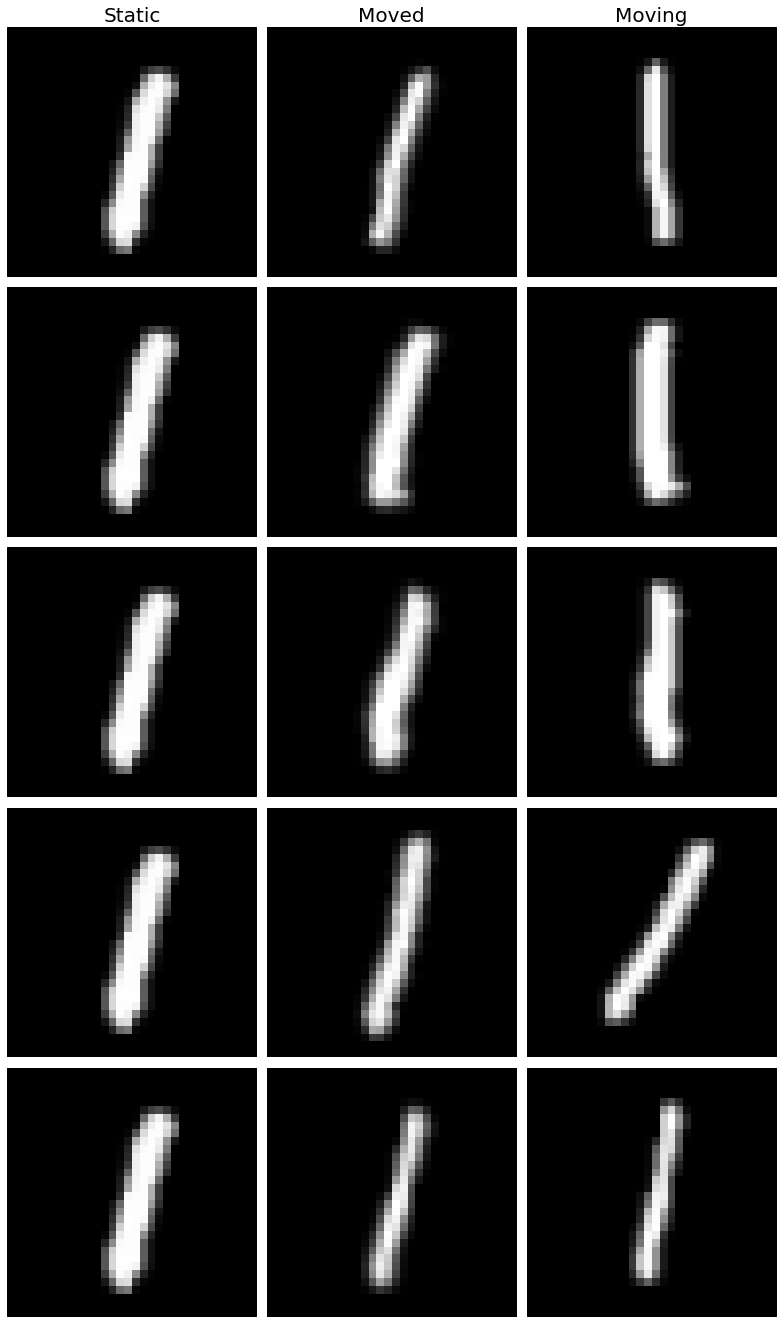

In [9]:
# Select some images from the test set to show sample results.
ids = tf.constant(np.random.choice(mnist_test.shape[0], replace=False,
            size=5))
x_sample = tf.gather(mnist_test, ids)
idx = 919
static = tf.expand_dims(mnist_test[idx], axis=0)
plot_images(model_post_training,x_sample,static)